# AI4IA Hackathon Phase 1

L'équipe LearnEverything:
- NGO Dam-Dung
- NGUYEN Le-Nhan

# 1. Chargement des Modules

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import importlib

import torch

import tarfile

%matplotlib inline

# 2. Jouer avec les données

On utilise le même modèle dans le script fourni my_model1.py afin de jouer avec les données.
Surtout, **il faut faire attention au shape de tensor de sortie**. On utilise la méthode *transpose()* au lieu de *view()* pour le reshape du tensor y (`y = torch.tensor(ys,dtype=float).view(x.shape[0],-1)` -> `y = torch.tensor(ys,dtype=float).transpose(1, 0)`). Cette méthode nous permet de garder bien l'ordre des éléments dans le tensor y. 

In [2]:
import sys
from importlib import reload,import_module
import os
from sources.utilities.utility_functions import *

model_definition = 'model_gru'
MyModel = import_module('sources.utilities.' + model_definition).MyModel

In [3]:
!python3 sources/utilities/test_submission.py model_gru

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


On visualise les données:

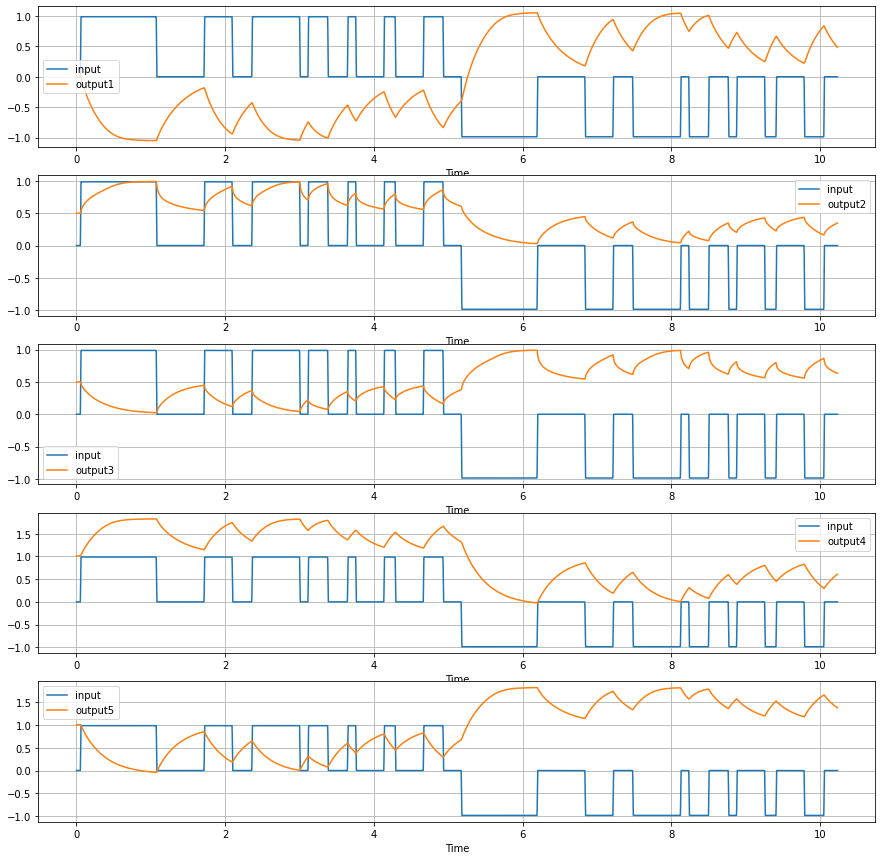

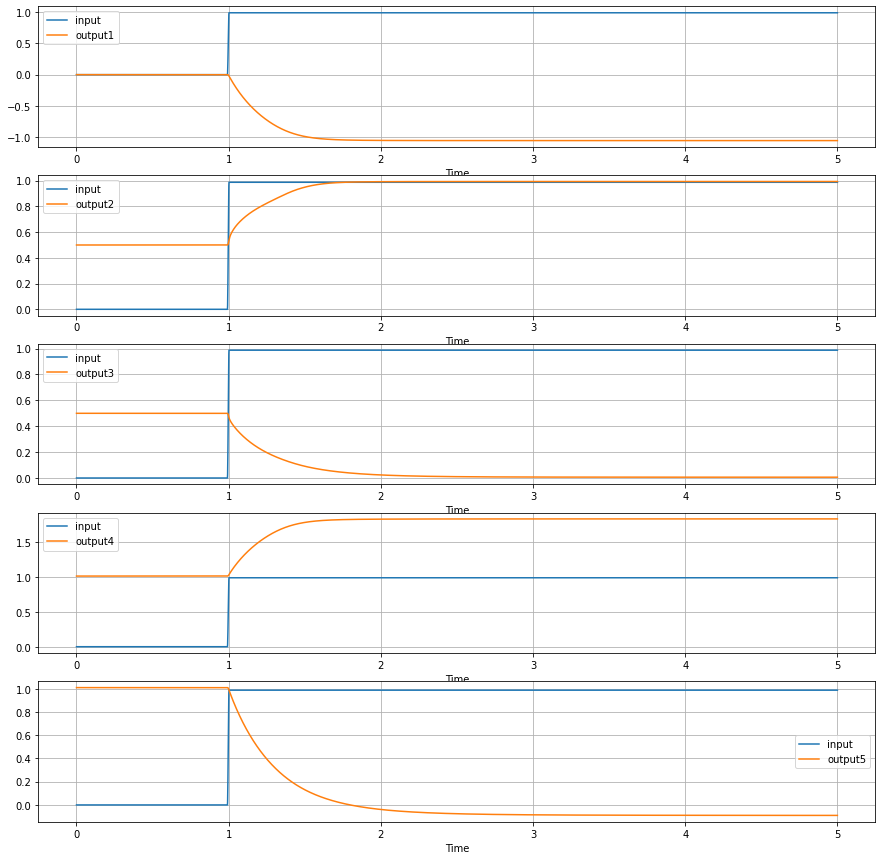

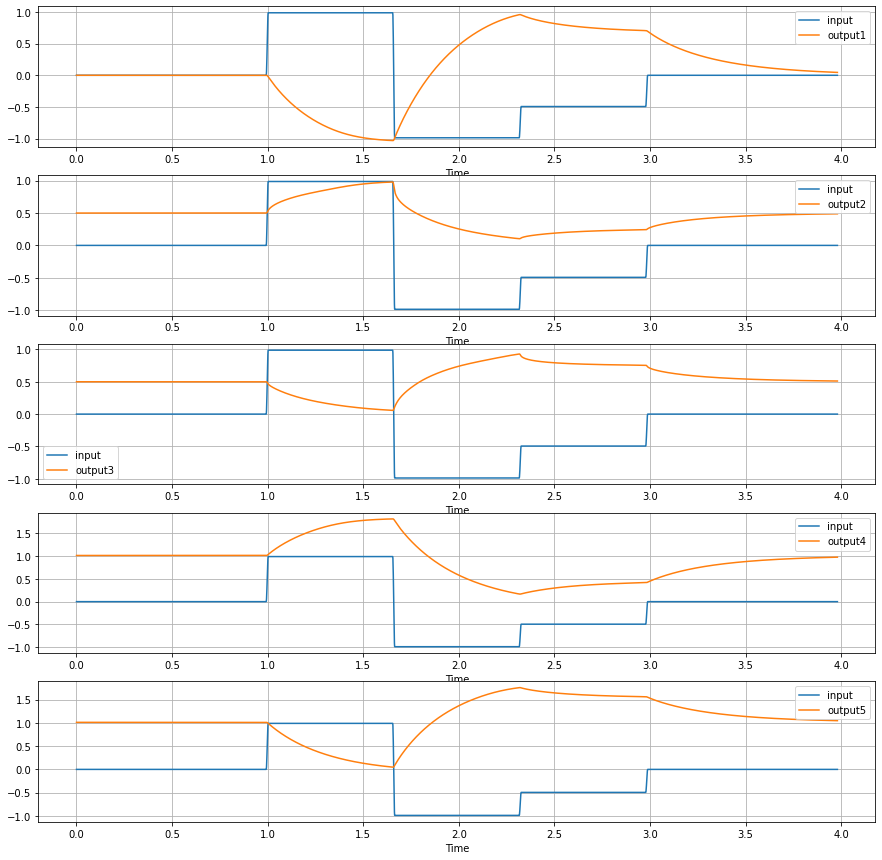

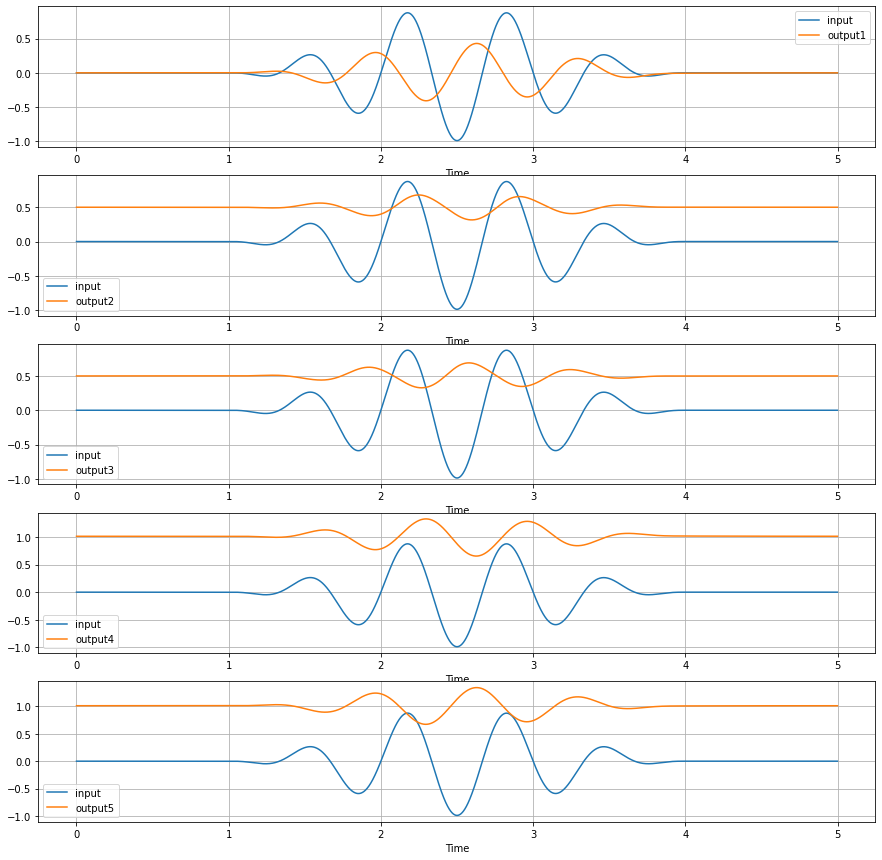

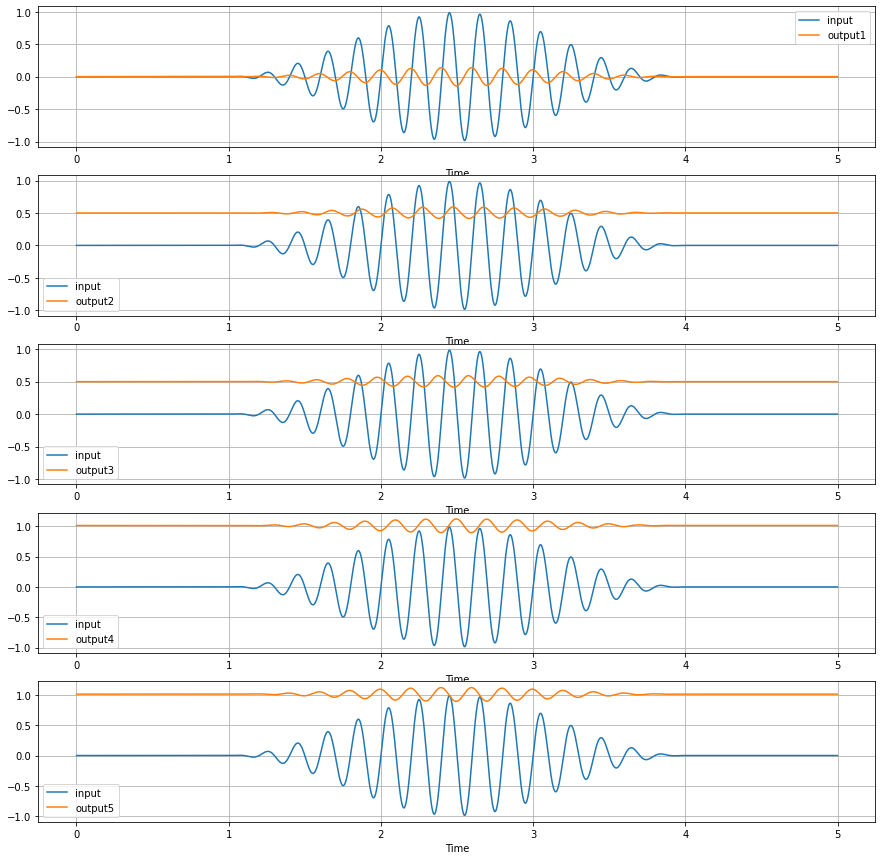

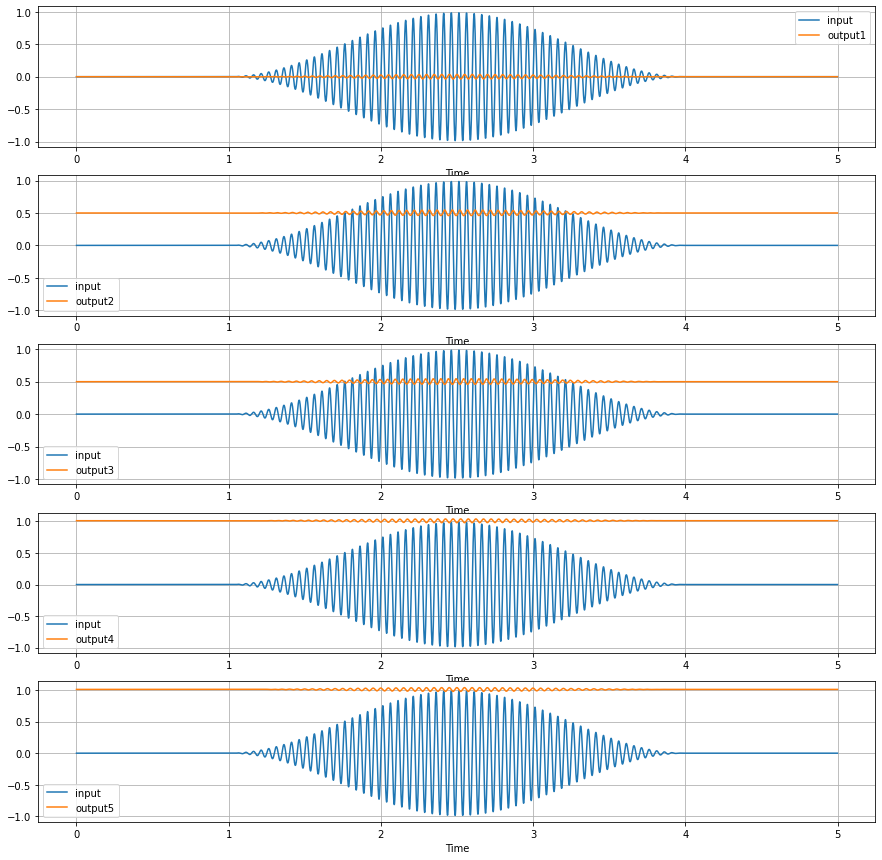

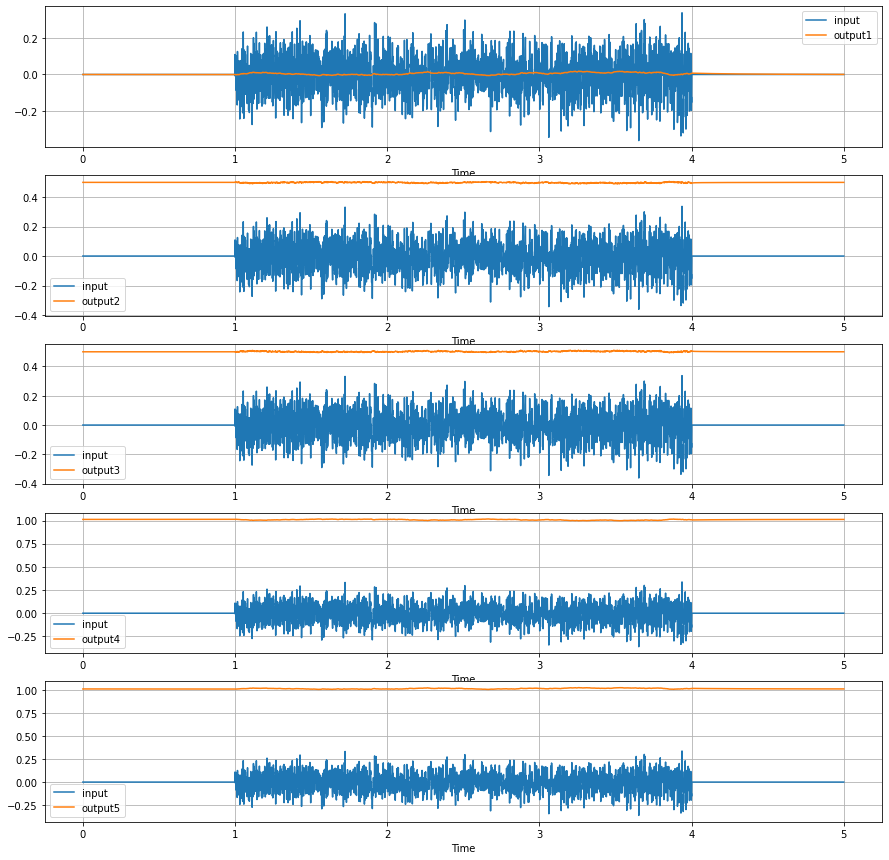

In [4]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for ii,k in enumerate(["output"+str(i) for i in range(1,6)]):
        d[name].plot(ax=ax[ii],x='Time',y=['input',k],grid='on')

On essaye de l'apprentissage du modèle sur une seule donnée puis de le valider sur les autres.

In [5]:
rep_data   = "data/DataSet_phase1/"
file_train = "input2.csv"
Ndecim=1
t_train,x_train,y_train = load_data_csv(rep_data+file_train, Ndecim=Ndecim)

In [6]:
outputs_indexes = [0,1,2,3,4]
model = MyModel.create_model(torch.cuda.is_available(),nlayers=1, hidden_layer_size=512, epochs=500, lr=0.001, output_size = len(outputs_indexes))
model.fit(xs=[x_train],ys=[y_train[:,k] for k in outputs_indexes])

it. 0 / 500 - loss = 0.62013334
it. 5 / 500 - loss = 0.14446479
it. 10 / 500 - loss = 0.26284984
it. 15 / 500 - loss = 0.35192531
it. 20 / 500 - loss = 0.35992521
it. 25 / 500 - loss = 0.34267366
it. 30 / 500 - loss = 0.31242144
it. 35 / 500 - loss = 0.27255839
it. 40 / 500 - loss = 0.22203572
it. 45 / 500 - loss = 0.15924732
it. 50 / 500 - loss = 0.09244651
it. 55 / 500 - loss = 0.07443956
it. 60 / 500 - loss = 0.07285250
it. 65 / 500 - loss = 0.05943466
it. 70 / 500 - loss = 0.05830412
it. 75 / 500 - loss = 0.05443807
it. 80 / 500 - loss = 0.04733381
it. 85 / 500 - loss = 0.03969396
it. 90 / 500 - loss = 0.02987061
it. 95 / 500 - loss = 0.02383728
it. 100 / 500 - loss = 0.01858156
it. 105 / 500 - loss = 0.01405653
it. 110 / 500 - loss = 0.00977413
it. 115 / 500 - loss = 0.00565158
it. 120 / 500 - loss = 0.00322888
it. 125 / 500 - loss = 0.00295160
it. 130 / 500 - loss = 0.00275135
it. 135 / 500 - loss = 0.00238549
it. 140 / 500 - loss = 0.00214621
it. 145 / 500 - loss = 0.00204250
it

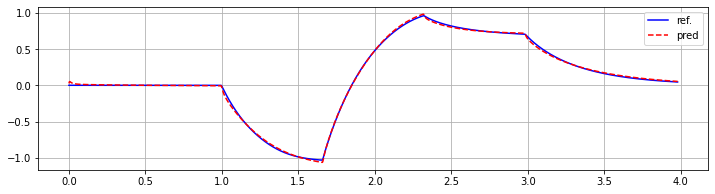

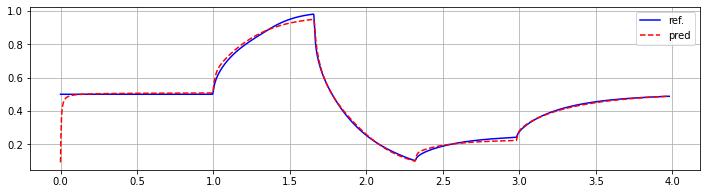

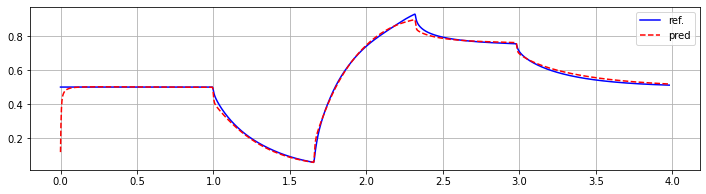

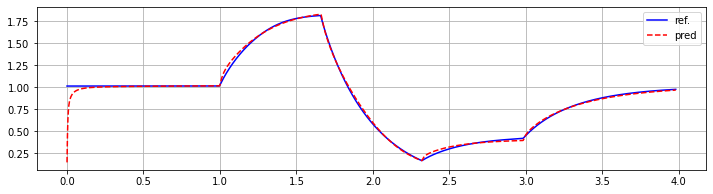

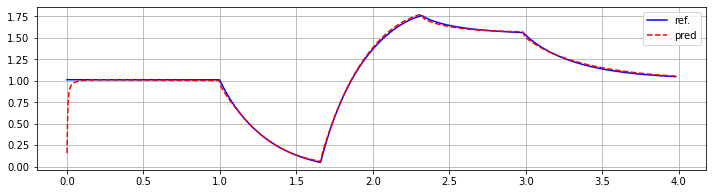

In [9]:
y_pred_train = model.predict_timeseries(x_train[::Ndecim])
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(t_train[::Ndecim],y_train[::Ndecim,outputs_indexes[k]],'b',t_train[::Ndecim],y_pred_train[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

On teste le modèle entraîné.

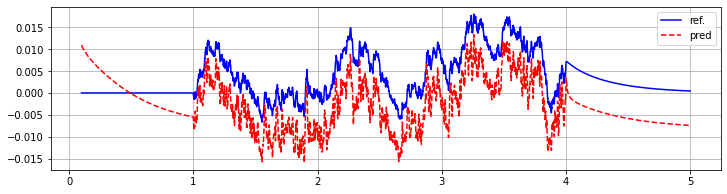

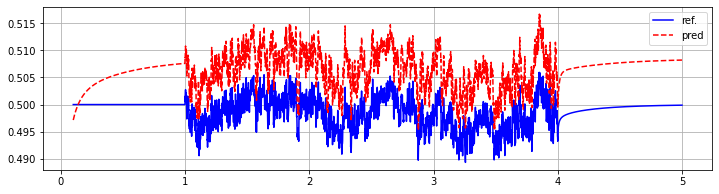

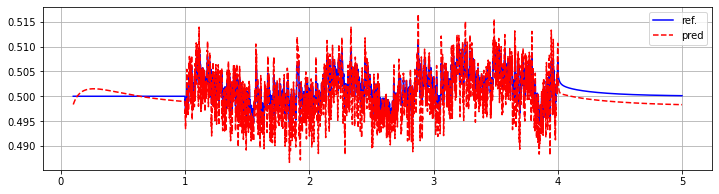

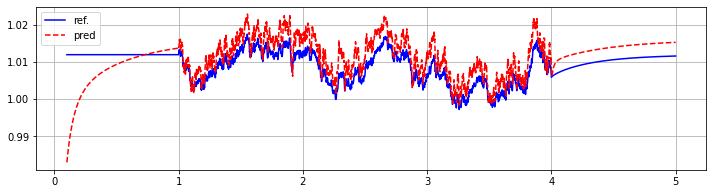

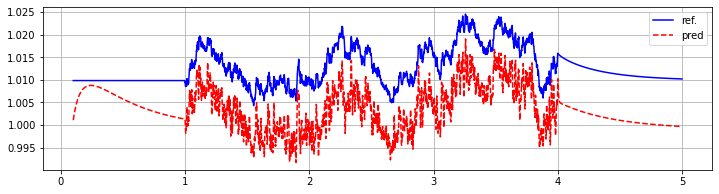

In [10]:
file_test  = "input6.csv"
Ndecim=1
t_test,x_test,y_test = load_data_csv(rep_data+file_test,Ndecim=Ndecim)

y_pred = model.predict_timeseries(x_test)
start = 100  # skip some first values
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(t_test[start:],y_test[start:,outputs_indexes[k]],'b',t_test[start:],y_pred[start:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

Cependant, il n’y a que la validation du modèle sur la donnée input5 qui n’est pas encore très excellente.
Le modèle est alors entraîné sur les deux données input2 et input5

In [17]:
import random

model_definition = "model_gru"
MyModel = import_module('sources.utilities.' + model_definition).MyModel
Ndecim = 1
outputs_indexes = [0,1,2,3,4]
rep_data   = "data/DataSet_phase1/"
list_train = [2,5]
model = MyModel.create_model(torch.cuda.is_available(), nlayers=1, hidden_layer_size=512, epochs=1,lr=0.001, output_size = len(outputs_indexes))

epoch = 500
for i in range(epoch):
    print('------Epoch:', i)
    random.shuffle(list_train)
    for input_train in list_train:
        print('Input ', input_train)
        file_train = "input{}.csv".format(input_train)
        t_train,x_train,y_train = load_data_csv(rep_data+file_train, Ndecim = Ndecim)
        model.fit(xs=[x_train], ys=[y_train[::Ndecim, k] for k in outputs_indexes])

------Epoch: 0
Input  5
it. 0 / 1 - loss = 0.49813840
Input  2
it. 0 / 1 - loss = 0.57330620
------Epoch: 1
Input  2
it. 0 / 1 - loss = 0.50538331
Input  5
it. 0 / 1 - loss = 0.29722223
------Epoch: 2
Input  5
it. 0 / 1 - loss = 0.19681017
Input  2
it. 0 / 1 - loss = 0.17219457
------Epoch: 3
Input  5
it. 0 / 1 - loss = 3.34262276
Input  2
it. 0 / 1 - loss = 0.13677093
------Epoch: 4
Input  5
it. 0 / 1 - loss = 0.06385650
Input  2
it. 0 / 1 - loss = 0.25145629
------Epoch: 5
Input  2
it. 0 / 1 - loss = 0.29584908
Input  5
it. 0 / 1 - loss = 0.21306321
------Epoch: 6
Input  2
it. 0 / 1 - loss = 0.34629419
Input  5
it. 0 / 1 - loss = 0.25142607
------Epoch: 7
Input  2
it. 0 / 1 - loss = 0.36881277
Input  5
it. 0 / 1 - loss = 0.27025694
------Epoch: 8
Input  2
it. 0 / 1 - loss = 0.37789959
Input  5
it. 0 / 1 - loss = 0.27821174
------Epoch: 9
Input  2
it. 0 / 1 - loss = 0.37898996
Input  5
it. 0 / 1 - loss = 0.27963343
------Epoch: 10
Input  2
it. 0 / 1 - loss = 0.37488925
Input  5
it. 0 

On calcule la valeur MSE moyenne.

In [19]:
from sklearn.metrics import mean_squared_error
list_validation = [0,1,2,3,4,5,6]
Ndecim = 1
errors = []
for i in list_validation:
    file_test  = f"input{i}.csv"
    t_test,x_test,y_test = load_data_csv(rep_data+file_test,Ndecim=Ndecim)
    y_pred = model.predict_timeseries(x_test)
    for k in range(len(outputs_indexes)):
        max_ytest_value = np.max(np.abs(y_test[:,k]))
        error = mean_squared_error(y_true=y_test[:,k]/max_ytest_value,y_pred=y_pred[:,k]/max_ytest_value)
        errors.append(error)
print('Metric: ', np.mean(errors))

Metric:  0.0010124728821572554


**Si on teste sur toutes les 6 données (sauf la donnée pour l'entraînement), on peut voir que les sorties prédites sont très proches aux sorties de ground-truth.** C'est à dire, le modèle fourni est déjà très fort pour éviter tous les deux problèmes de *underfitting* et *overfitting*.

**Le modèle est enregistré dans le models/dossier model_gru_ndecim_1.**

# 3. Jouer avec la valeur Ndecim

Cependant, si on change la valeur Ndecim pour le test, le résultat n'est plus bon. Par exemple, on change la valeur Ndecim = 5.

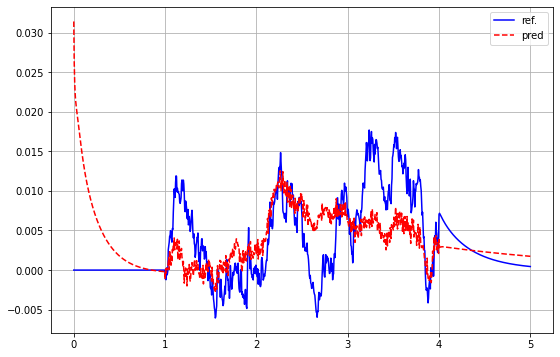

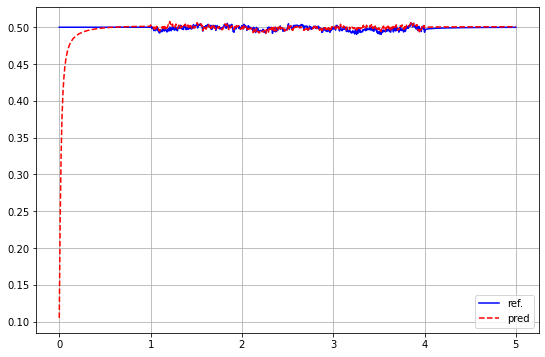

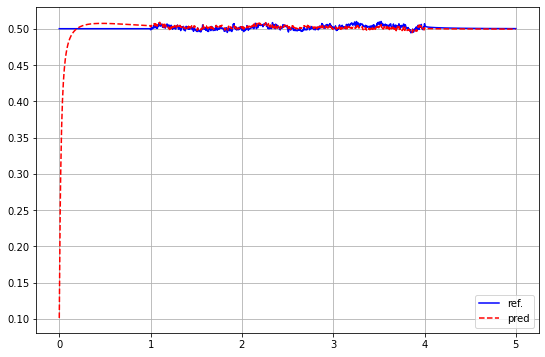

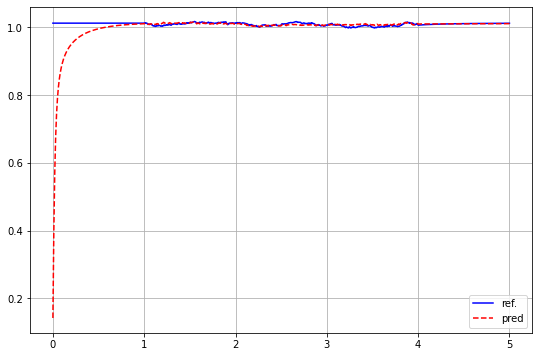

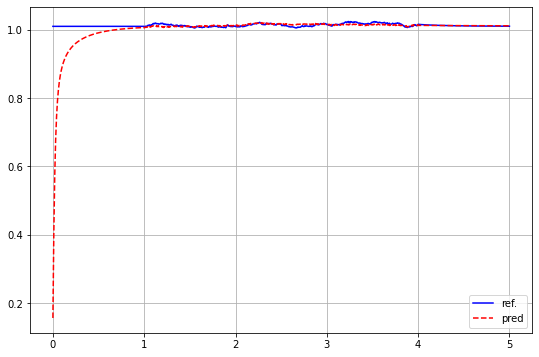

In [20]:
Ndecim=5

file_test  = "input6.csv"
t_test,x_test,y_test = load_data_csv(rep_data+file_test)

y_pred = model.predict_timeseries(x_test[::Ndecim])

for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(9,6))
    ax.plot(t_test[::Ndecim],y_test[::Ndecim,outputs_indexes[k]],'b',t_test[::Ndecim],y_pred[:,k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

Par conséquent, on essaye de l'entraînement du modèle sur les données avec les valeurs Ndecim différentes (Ndecim = [1,2,3,4,5,6,7,8,9,10]). Le meilleur modèle va être enregistré dans le dossier *best_weight_multi_ndecim/* .

In [21]:
import os

path_best_model = 'models/best_weight_multi_ndecim/'
path_last_model = 'models/last_weight_multi_ndecim/'

# Check whether the specified path exists or not
isExist_best = os.path.exists(path_best_model)
isExist_last = os.path.exists(path_last_model)

if not isExist_best:
  
  # Create a new directory because it does not exist 
  os.makedirs(path_best_model)
  print("The best directory is created!")

if not isExist_last:
  # Create a new directory because it does not exist 
  os.makedirs(path_last_model)
  print("The last directory is created!")

In [27]:
import random
from sklearn.metrics import mean_squared_error

model_definition = "model_gru"
MyModel = import_module('sources.utilities.' + model_definition).MyModel

outputs_indexes = [0,1,2,3,4]
rep_data   = "data/DataSet_phase1/"
list_train = [2,4,6]
list_validation = [0,1,3,5]
list_Ndecim = [1,2,3,4,5,6,7,8,9,10]
best_metric = 1000
val_step = 5
model = MyModel.create_model(torch.cuda.is_available(), nlayers=2, hidden_layer_size=512, epochs=1,lr=0.001, output_size = len(outputs_indexes))

epoch = 500
for i in range(epoch):
    print('------Epoch:', i)
    random.shuffle(list_train)
    for input_train in list_train:
        print('Input ', input_train)
        file_train = "input{}.csv".format(input_train)
        random.shuffle(list_Ndecim)
        for decim in list_Ndecim:
            t_train,x_train,y_train = load_data_csv(rep_data+file_train,Ndecim=decim)
            model.fit(xs=[x_train], ys=[y_train[:,k] for k in outputs_indexes])
    if i%val_step == 0:
        errors = []
        for decim in list_Ndecim:    
            for i in list_validation:
                file_test  = f"input{i}.csv"
                t_test,x_test,y_test = load_data_csv(rep_data+file_test,Ndecim=decim)

                y_pred = model.predict_timeseries(x_test)
                for k in range(len(outputs_indexes)):
                    max_ytest_value = np.max(np.abs(y_test[:,k]))
                    error = mean_squared_error(y_true=y_test[:,k]/max_ytest_value,y_pred=y_pred[:,k]/max_ytest_value)
                    errors.append(error)
        if np.mean(errors) <= best_metric:
            best_metric = np.mean(errors)
            print('New best metric: ', best_metric)
            model.save(path_best_model)
model.save(path_last_model)
            

On teste sur les autres données avec les valeurs Ndecim différentes:

In [ ]:
file_test  = "input3.csv"
Ndecim=5
t_test,x_test,y_test = load_data_csv(rep_data+file_test, Ndecim=Ndecim)

y_pred = model.predict_timeseries(x_test)
start = 100
for k in range(len(outputs_indexes)):
    fig,ax = plt.subplots(1,1,figsize=(27,6))
    ax.plot(t_test[start:],y_test[start:,outputs_indexes[k]],'b',t_test[start:],y_pred[start:, k],'--r') 
    plt.grid()
    plt.legend(["ref.","pred"])

**Le modèle avec le meilleur résultat est enregistré dans le models/dossier model_gru_multi_ndecim.**

# 4. Lancement de l'entraînement

Grâce au résultat de l'experiment dans le fichier *result_collect.xlsx*, la données input2 est choisie pour l’entraînement avec la valeur Ndecim = 1.

In [26]:
rep = "data/DataSet_phase1/"
file_train = "input2.csv"
data = rep + file_train

model_definition = "model_gru"

use_gpu = True
epochs = 500
model_dir = "./models/model_gru"
model_name = "model_gru"
lr = 0.001
Ndecim = 1
outputs_indexes = [0,1,2,3,4]
outputs_ind = ','.join([str(k+1) for k in outputs_indexes])
hyper_fileName = "hyper.json"

%run sources/sagemaker_api.py --use_gpu $use_gpu --lr $lr --epochs $epochs \
                              --data_dir $rep --train_fileName $file_train --model_dir $model_dir \
                              --outputs_indexes $outputs_ind --Ndecim $Ndecim --hyper_fileName $hyper_fileName \
                              --model_def_file $model_definition 

On teste le modèle:

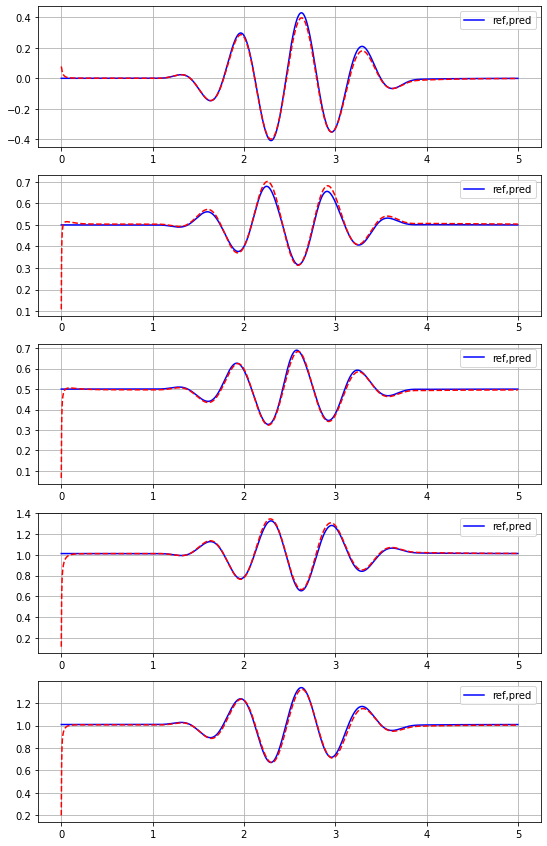

In [20]:
model = MyModel.load(model_dir)

file_test  = "input3.csv"
t_test,x_test,y_test = load_data_csv(rep+file_test,Ndecim=Ndecim)
y_pred = model.predict_timeseries(x_test)
No = len(outputs_indexes)


fig,ax = plt.subplots(No,1,figsize=(9,3*No))
if No>1:
    for k in range(No):
        ax[k].plot(t_test,y_test[:,outputs_indexes[k]],'b',t_test,y_pred[:,k],'--r')
        ax[k].grid()
        ax[k].legend(['ref,pred'])
else:
    ax.plot(t_test,y_test[:,outputs_indexes[0]],'b',t_test,y_test[:,0],'--r')
    ax.grid()
    ax.legend(['ref,pred'])  
    
plt.show()

# 5. Evaluation

Recuperation des paramètres (modele et entraînement):

In [21]:
data_dir = "./data/DataSet_phase1"
hyper_filename  = "hyper.json"
kwargs_filename = "model_kwargs.json"
test_filename   = 'input3.csv'
model_dir       = './models/model_gru'
model_def_file  = 'model_gru'

%run sources/calc_metrics.py --data_dir $data_dir \
                             --model_dir $model_dir \
                             --estimator_hyperParams_fileName $hyper_fileName \
                             --model_kwargs_fileName $kwargs_filename \
                             --test_fileName $test_filename \
                             --model_def_file $model_def_file


./models/model_gru/hyper.json
it. 0 / 500 - loss = 0.66073930
it. 20 / 500 - loss = 0.15942736
it. 40 / 500 - loss = 0.06439380
it. 60 / 500 - loss = 0.05206664
it. 80 / 500 - loss = 0.02374541
it. 100 / 500 - loss = 0.00616373
it. 120 / 500 - loss = 0.00201771
it. 140 / 500 - loss = 0.00104120
it. 160 / 500 - loss = 0.00071908
it. 180 / 500 - loss = 0.00061373
it. 200 / 500 - loss = 0.00055781
it. 220 / 500 - loss = 0.00051792
it. 240 / 500 - loss = 0.00048821
it. 260 / 500 - loss = 0.00046772
it. 280 / 500 - loss = 0.00045218
it. 300 / 500 - loss = 0.00044084
it. 320 / 500 - loss = 0.00043245
it. 340 / 500 - loss = 0.00042598
it. 360 / 500 - loss = 0.00041976
it. 380 / 500 - loss = 0.00041361
it. 400 / 500 - loss = 0.00040755
it. 420 / 500 - loss = 0.00040157
it. 440 / 500 - loss = 0.00039568
it. 460 / 500 - loss = 0.00038988
it. 480 / 500 - loss = 0.00038416


<Figure size 432x288 with 0 Axes>

In [25]:
with open('./metrics/LearnEverything_GRU_metrics','r') as f: print(f.read())

affiliation : 
description : This is a simple GRU model that supports 1 input and 1 to 5 outputs
email : ngodamdung611@gmail.com
model_name : GRU
other_remarks : 
team_name : LearnEverything
technology_stack : pytorch
Aggregated Metrics : 0.006245062097558922
Average inference time [seconds] : 6.880474090576172e-05
Normalized MSE : [0.00067696 0.00030568 0.00025125 0.00043091 0.00034909]
Normalized MSE Sum : 0.0020138902977667374
Training set size : 3981
Training time [seconds] : 652.9214119911194

